In [27]:
# Install system packages
!apt-get install -y poppler-utils tesseract-ocr

# Install Python packages
!pip install pdfplumber pdf2image pytesseract pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [28]:
import pdfplumber
import re
from pdf2image import convert_from_path
from PIL import Image
import pytesseract

In [29]:
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

In [30]:
def extract_text_from_pdf(file_path):
    text = ""
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            # Extract text using pdfplumber
            page_text = page.extract_text()
            if page_text:
                text += page_text
            # Convert PDF page to image
            image = page.to_image()
            # Perform OCR on the image
            ocr_text = pytesseract.image_to_string(image.original)
            text += ocr_text
    # Clean the text
    text = re.sub(r'\s+', ' ', text)
    return text


In [31]:
# def extract_images_from_pdf(file_path, output_folder):
#     with pdfplumber.open(file_path) as pdf:
#         for i, page in enumerate(pdf.pages):
#             for j, image in enumerate(page.images):
#                 # Extract image bytes
#                 image_bytes = page.within_bbox((image['x0'], image['top'], image['x1'], image['bottom'])).to_image()
#                 # Save image
#                 image_path = f"{output_folder}/page_{i+1}_image_{j+1}.png"
#                 image_bytes.save(image_path)

def extract_images_from_pdf(file_path, output_folder):
    with pdfplumber.open(file_path) as pdf:
        for i, page in enumerate(pdf.pages):
            for j, image in enumerate(page.images):
                # Get page boundaries
                page_width = page.width
                page_height = page.height

                # Clamp image coordinates to page boundaries
                x0 = max(0, int(image['x0']))
                top = max(0, int(image['top']))
                x1 = min(page_width, int(image['x1']))
                bottom = min(page_height, int(image['bottom']))

                # Extract image bytes
                image_bytes = page.within_bbox((x0, top, x1, bottom)).to_image()

                # Save image
                image_path = f"{output_folder}/page_{i+1}_image_{j+1}.png"
                image_bytes.save(image_path)

In [32]:
file_path = "/content/pcos-dietary-advice_nov22.pdf"
output_folder = "/content/extracted_images"

In [33]:
import os

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


In [34]:
# Extract and clean text
document_text = extract_text_from_pdf(file_path)

# Extract images
extract_images_from_pdf(file_path, output_folder)

In [35]:
# cell 9
def chunk_text_sliding_window(text, chunk_size=500, overlap=100):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks


In [36]:
chunks = chunk_text_sliding_window(document_text)


In [37]:
#cell 11
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(chunks, show_progress_bar=True)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
!pip install faiss-cpu

In [39]:
#cell 13
import faiss
import numpy as np

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))


In [40]:
!pip install cohere

In [41]:
import cohere

cohere_client = cohere.Client('Your-api-key')  # Replace with your actual API key


In [42]:
#cell 16
def retrieve_relevant_chunks(query, top_k=5):
    query_embedding = embedding_model.encode([query])
    distances, indices = index.search(np.array(query_embedding), top_k)
    return [chunks[i] for i in indices[0]]

def generate_answer(query):
    relevant_chunks = retrieve_relevant_chunks(query)
    context = " ".join(relevant_chunks)
    prompt = f"Context: {context}\n\nQuestion: {query}\n\nAnswer:"
    response = cohere_client.generate(
        model="command-xlarge-nightly",
        prompt=prompt,
        max_tokens=300,
        temperature=0.3
    )
    return response.generations[0].text.strip()


In [43]:
query = "What are the meals that i need to take on Monday ?"
answer = generate_answer(query)
print(answer)


I don't have specific information about meals for Monday, but I can provide you with some general dietary guidelines and meal ideas for people with PCOS.

- **Breads, cereals, grains, and starchy vegetables:** Each serving should contain 15 grams of carbohydrates and about 80-100 calories. Examples include a medium slice of bread, a small baked potato, a roll, uncooked pasta, oats, corn on the cob, crackers, rice cakes, etc.

- **Fruits:** Aim for two portions of fruit per day. A portion is one handful or approximately 80g, containing 15g of carbohydrates and 60-20 calories.

- **Dairy:** Aim for three portions per day to meet your calcium requirements, which are increased in PCOS. A portion could be a 200ml glass of milk, 125g of yogurt, or a matchbox-sized piece of cheese (25g).

- **Meal ideas to reduce the Glycemic Index (GI):**
   - Add beans, pulses, or extra vegetables to meals.
   - Include lean proteins and healthy fats to balance the meal.
   - Switch to wholegrain/wholewheat

In [44]:
query = "Who is the ceo?"
answer = generate_answer(query)
print(answer)


I'm sorry, but the text does not provide any information about the CEO.


In [45]:
query = "Which year's report is this?"
answer = generate_answer(query)
print(answer)

The report is from November 2022.


In [46]:
query = "Give description of the company's financial perfomance?"
answer = generate_answer(query)
print(answer)

The text provided does not contain any information about a company's financial performance. It is a dietary advice leaflet for women with Polycystic Ovary Syndrome (PCOS), which is a common disorder affecting ovarian function in pre-menopausal women. The leaflet offers guidance on managing PCOS symptoms through diet and lifestyle changes, including information on portion sizes, the Glycaemic Index, and recommended books and websites for further reading.


In [47]:
query = " Company's initiatives towards supporting the communities?"
answer = generate_answer(query)
print(answer)

It looks like the text you provided does not contain any information about a company's initiatives towards supporting the communities. The text is a leaflet about Polycystic Ovary Syndrome (PCOS) and provides dietary and lifestyle advice for managing its symptoms. It includes information about the condition, tips to improve insulin resistance, and recommendations for sleeping well. The leaflet also mentions medications that can be used to treat PCOS symptoms and provides a list of helpful resources and references.


In [48]:
query = "What is the Company's share price?"
answer = generate_answer(query)
print(answer)

I'm sorry, but I cannot answer your question. The text provided does not contain any information about a company's share price. It is a leaflet that offers dietary and lifestyle advice for managing the symptoms of Polycystic Ovary Syndrome (PCOS).


In [49]:
query = "What are some of the struck off companies?"
answer = generate_answer(query)
print(answer)

I'm sorry, but the provided text does not contain any information about struck-off companies. It is a document containing dietary advice for people with Polycystic Ovary Syndrome (PCOS), including information on portion sizes, the Glycaemic Index, exercise, sleep, and specific diets for PCOS.


In [50]:
query = "what is Panatone Finvest Limited's relation to tata communications?"
answer = generate_answer(query)
print(answer)

The text does not mention Panatone Finvest Limited or tata communications.


In [51]:
#cell 25
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
def create_similarity_graph(chunks, embeddings, similarity_threshold=0.7):
    """
    Create a similarity graph where nodes are chunks of text and edges represent similarity.

    Parameters:
        chunks (list): List of text chunks.
        embeddings (np.ndarray): Corresponding embeddings for the chunks.
        similarity_threshold (float): Minimum similarity score to create an edge.

    Returns:
        nx.Graph: A graph with chunks as nodes and similarity-based edges.
    """
    G = nx.Graph()

    # Add nodes to the graph
    for i, chunk in enumerate(chunks):
        G.add_node(i, text=chunk)

    # Compute cosine similarity and add edges
    similarity_matrix = cosine_similarity(embeddings)
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] >= similarity_threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    return G


In [52]:
# Create a similarity graph for the text chunks
similarity_graph = create_similarity_graph(chunks, np.array(embeddings))


In [53]:
#cell 27
def retrieve_relevant_chunks_graph(query, graph, embeddings, top_k=5):
    """
    Retrieve relevant chunks using the graph structure and query embedding.

    Parameters:
        query (str): The input query.
        graph (nx.Graph): The similarity graph.
        embeddings (np.ndarray): Embeddings of the text chunks.
        top_k (int): Number of top chunks to retrieve.

    Returns:
        list: List of relevant text chunks.
    """
    query_embedding = embedding_model.encode([query])[0]
    similarity_scores = cosine_similarity([query_embedding], embeddings)[0]

    # Find the most similar nodes
    similar_nodes = np.argsort(similarity_scores)[::-1][:top_k]
    relevant_chunks = [graph.nodes[node]['text'] for node in similar_nodes]

    return relevant_chunks


In [54]:
#cell 28
def generate_answer_with_rag(query, graph, embeddings):
    """
    Generate an answer using GraphRAG.

    Parameters:
        query (str): The input query.
        graph (nx.Graph): The similarity graph.
        embeddings (np.ndarray): Embeddings of the text chunks.

    Returns:
        str: The generated answer.
    """
    relevant_chunks = retrieve_relevant_chunks_graph(query, graph, embeddings)
    context = " ".join(relevant_chunks)
    prompt = f"Context: {context}\n\nQuestion: {query}\n\nAnswer:"
    response = cohere_client.generate(
        model="command-xlarge-nightly",
        prompt=prompt,
        max_tokens=500,
        temperature=0.3
    )
    return response.generations[0].text.strip()


In [60]:
query = "What are the meals that i need to take on a given week ?"
answer = generate_answer_with_rag(query, similarity_graph, np.array(embeddings))
print("Query:", query)
print("Answer:", answer)


Query: What are the meals that i need to take on a given week ?
Answer: The text does not specify a particular meal plan for a given week, but it does provide general dietary advice and guidelines for individuals with Polycystic Ovary Syndrome (PCOS). The document emphasizes the importance of a balanced diet that includes a variety of foods from different food groups.

Here are some key points from the text regarding meal choices:

- Breads, cereals, grains, and starchy vegetables: Each serving listed contains 15 grams of carbohydrates and about 80-100 calories. Examples include a medium slice of bread, a small baked potato, a roll, uncooked pasta, cooked pasta, couscous, rice, and more.

- Fruits: Aim for two portions of fruit per day. A portion is one handful or approximately 80g, containing 15g of carbohydrates and 60-20 calories.

- Dairy: Aim for three portions per day to meet calcium requirements, which are increased in PCOS. Examples include 200ml of milk, 125g of yogurt, or a m

In [56]:
query = "Give description of the company's financial perfomance?"
answer = generate_answer_with_rag(query, similarity_graph, np.array(embeddings))
print("Query:", query)
print("Answer:", answer)


Query: Give description of the company's financial perfomance?
Answer: The text provided does not contain any information about a company's financial performance. It is a dietary advice leaflet for women with Polycystic Ovary Syndrome (PCOS), which is a common disorder affecting ovarian function in pre-menopausal women. The leaflet offers guidance on managing PCOS symptoms through diet and lifestyle changes, such as losing weight, controlling carbohydrate intake, and improving insulin resistance. It also provides information on the Glycaemic Index, portion sizes, and recommended foods to help women with PCOS make healthier choices.


In [57]:
query = "Company's initiatives towards supporting the communities?"
answer = generate_answer_with_rag(query, similarity_graph, np.array(embeddings))
print("Query:", query)
print("Answer:", answer)

Query: Company's initiatives towards supporting the communities?
Answer: It looks like the text you provided does not contain any information about a company's initiatives to support the community. The text is a leaflet about Polycystic Ovary Syndrome (PCOS) and provides dietary and lifestyle advice for managing PCOS symptoms. It includes information about the condition, its symptoms, and the importance of maintaining a healthy weight through sustainable dietary changes. The leaflet also offers tips for improving insulin resistance, sleeping well, and managing carbohydrate cravings and emotional eating. It suggests seeking support through cognitive behavioral therapy or medications and provides a list of helpful resources, including books, websites, and a local service called Talking Therapies.


In [58]:
query = "What is the Company's share price in March 2024?"
answer = generate_answer_with_rag(query, similarity_graph, np.array(embeddings))
print("Query:", query)
print("Answer:", answer)

Query: What is the Company's share price in March 2024?
Answer: I'm sorry, but I cannot answer that question. The text provided does not contain information about a company's share price in March 2024. The text is a leaflet from the Berkshire Healthcare NHS Foundation Trust that provides dietary and lifestyle advice for managing the symptoms of Polycystic Ovary Syndrome (PCOS).


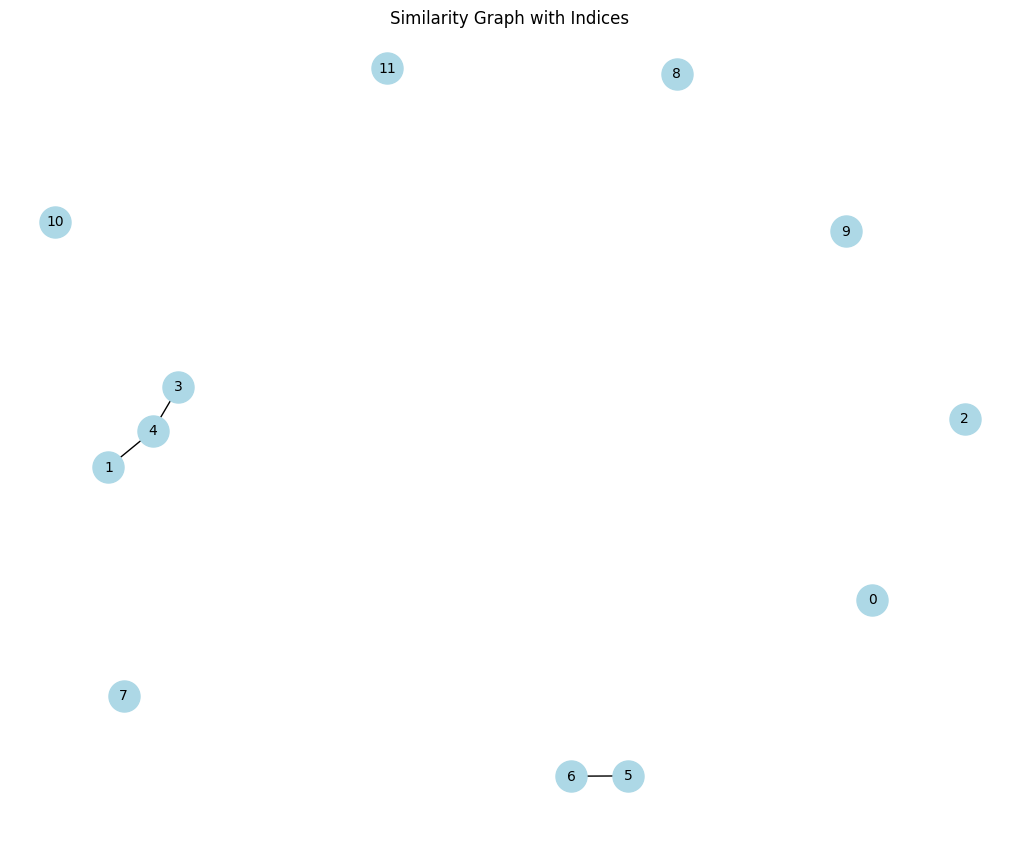

'/content/index_to_chunk_mapping.txt'

In [59]:
#cell 32
def visualize_graph_and_create_mapping(graph, chunks, output_file_path):
    """
    Visualize the graph with indices as node labels and save a mapping of indices to text chunks.

    Parameters:
        graph (nx.Graph): The similarity graph.
        chunks (list): List of text chunks.
        output_file_path (str): Path to save the index-to-chunk mapping as a text file.
    """
    # Visualize the graph with indices as labels
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(10, 8))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', font_size=10, node_size=500)
    plt.title("Similarity Graph with Indices")
    plt.show()

    # Save the mapping of indices to text chunks
    with open(output_file_path, 'w') as file:
        for i, chunk in enumerate(chunks):
            file.write(f"Index {i}: {chunk}\n")

# File path to save the mapping
output_file_path = '/content/index_to_chunk_mapping.txt'

# Assuming `similarity_graph` is your graph and `chunks` is the list of text chunks
visualize_graph_and_create_mapping(similarity_graph, chunks, output_file_path)

# Output the file path to verify where the mapping is saved
output_file_path
